<a href="https://colab.research.google.com/github/UmeshGayashan/OCR_RegNo_Detection/blob/main/OCR_RegNo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
## Go to the drive and get the data
```



In [1]:
# !-shell command, -q -quiet mode, -U -upgrade
# download files and folders from Google Drive
!pip install -qU gdown
!pip install easyocr

# Mount Google Drive directly
from google.colab import drive
drive.mount('/content/gdrive')

# Verify dataset access using native path
import os

dataset_path = '/content/gdrive/MyDrive/OCR_dataset'
if os.path.exists(dataset_path):
    print(f"Found {len(os.listdir(dataset_path))} files:")
    for idx, file in enumerate(os.listdir(dataset_path), 1):
        print(f"{idx}. {file}")
else:
    print("Error: Folder not found. Check sharing permissions and folder name.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 136.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 734.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import easyocr
import os
import re
from difflib import get_close_matches

In [3]:
# Initialize OCR reader
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [4]:
def process_registration_number(image_path):
    # Load image
    image = cv2.imread(image_path)
    original = image.copy()

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply threshold to get binary image
    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area (descending)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # The registration number box is typically the second largest contour
    registration_box = contours[1]

    # Get bounding rectangle of the registration box
    x, y, w, h = cv2.boundingRect(registration_box)

    # Extract the registration box region
    roi = original[y:y+h, x:x+w]

    # Display the extracted region
    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.title("Extracted Registration Box")
    plt.axis('off')
    plt.show()

    # Preprocess ROI for better OCR
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # OCR to extract text
    results = reader.readtext(roi)

    # Combine OCR output
    raw_text = " ".join([res[1] for res in results])
    raw_text = raw_text.upper().replace("/", " ").replace("-", " ").replace("_", " ")

    # Match pattern using regex
    pattern = r"(EG|TE|SC)\s*(20[0-9]{2}|2100)\s*\d{4}"
    match = re.search(pattern, raw_text)

    if match:
        reg_number = match.group()
    else:
        reg_number = "[INVALID FORMAT]" + raw_text

    return roi, reg_number

In [5]:
def process_all_images(folder_path):
    results = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)

            # Extract ground truth from filename
            ground_truth = os.path.splitext(filename)[0].replace("_", " ")

            # Process image
            roi, predicted_reg = process_registration_number(image_path)

            # Store results
            results.append({
                'filename': filename,
                'ground_truth': ground_truth,
                'predicted': predicted_reg
            })

            print(f"File: {filename}")
            print(f"Ground Truth: {ground_truth}")
            print(f"Predicted: {predicted_reg}")
            print('-' * 40)

    return results

In [6]:
# Main execution code
dataset_path = '/content/gdrive/MyDrive/OCR_dataset'

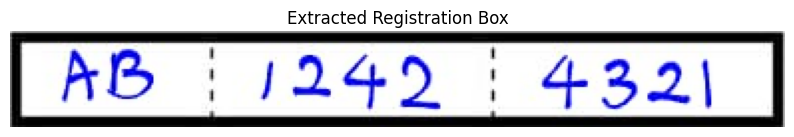

File: AB_1242_4321.jpg
Ground Truth: AB 1242 4321
Predicted: [INVALID FORMAT]AB 1242 4321
----------------------------------------


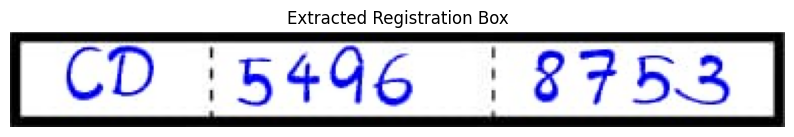

File: CD_5496_8753.jpg
Ground Truth: CD 5496 8753
Predicted: [INVALID FORMAT]CD 5496 8753
----------------------------------------


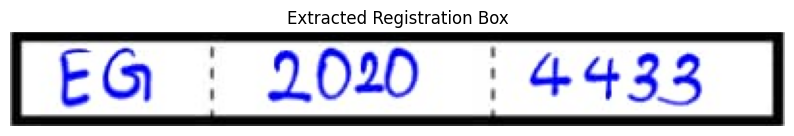

File: EG_2020_4433.jpg
Ground Truth: EG 2020 4433
Predicted: EG 2020 4433
----------------------------------------


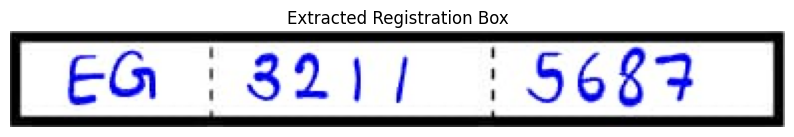

File: EG_3211_5687.jpg
Ground Truth: EG 3211 5687
Predicted: [INVALID FORMAT]EG 32 |   5687
----------------------------------------


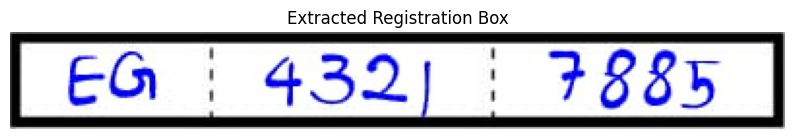

File: EG_4321_7885.jpg
Ground Truth: EG 4321 7885
Predicted: [INVALID FORMAT]EG 4321 7885
----------------------------------------


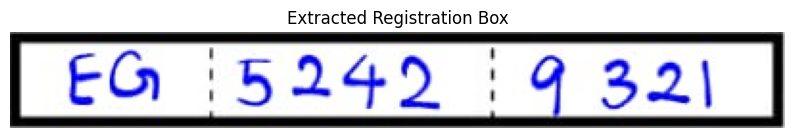

File: EG_5242_9321.jpg
Ground Truth: EG 5242 9321
Predicted: [INVALID FORMAT]EG 5242 321
----------------------------------------


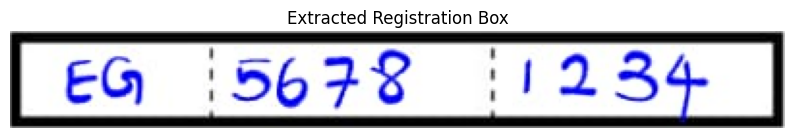

File: EG_5678_1234.jpg
Ground Truth: EG 5678 1234
Predicted: [INVALID FORMAT]EQ 567 8 7234
----------------------------------------


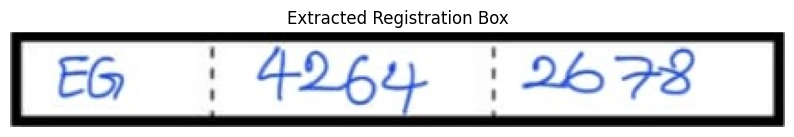

File: EG_2020_2678.jpeg
Ground Truth: EG 2020 2678
Predicted: [INVALID FORMAT]E6 4264 2678
----------------------------------------


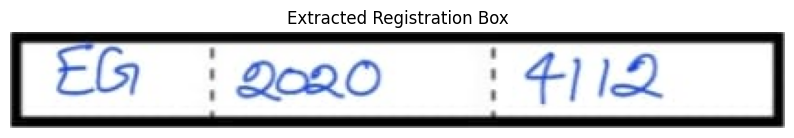

File: EG_2020_4112.jpeg
Ground Truth: EG 2020 4112
Predicted: [INVALID FORMAT]EG DO20 4112
----------------------------------------


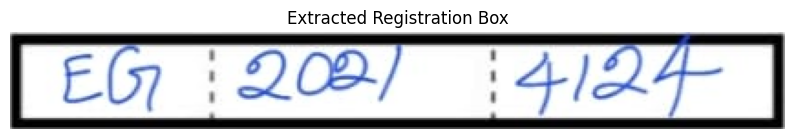

File: EG_2021_4124.jpeg
Ground Truth: EG 2021 4124
Predicted: [INVALID FORMAT]EG 201 412F
----------------------------------------


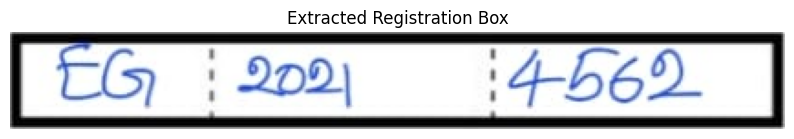

File: EG_2021_4562.jpeg
Ground Truth: EG 2021 4562
Predicted: [INVALID FORMAT]E6 202 | 4662
----------------------------------------


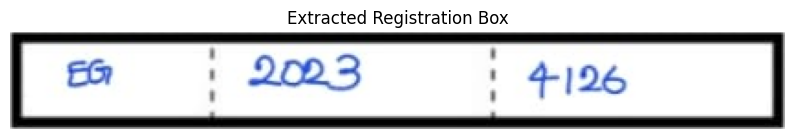

File: EG_2023_4126.jpeg
Ground Truth: EG 2023 4126
Predicted: [INVALID FORMAT]66 203 4126
----------------------------------------


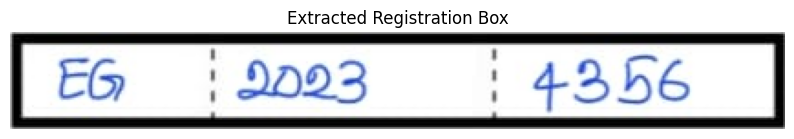

File: EG_2023_4356.jpeg
Ground Truth: EG 2023 4356
Predicted: [INVALID FORMAT]E6 9023 4356
----------------------------------------


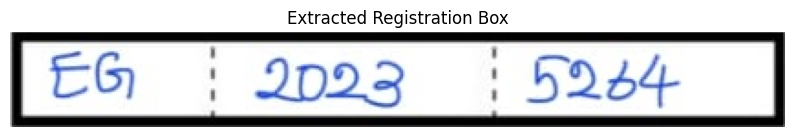

File: EG_2023_5264.jpeg
Ground Truth: EG 2023 5264
Predicted: EG 2023 5284
----------------------------------------


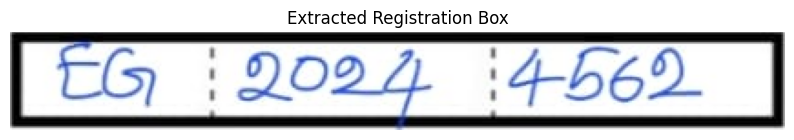

File: EG_2024_4562.jpeg
Ground Truth: EG 2024 4562
Predicted: [INVALID FORMAT]E6 2024 4B62
----------------------------------------


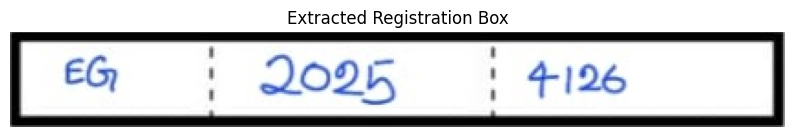

File: EG_2025_4126.jpeg
Ground Truth: EG 2025 4126
Predicted: EG 2025 4126
----------------------------------------


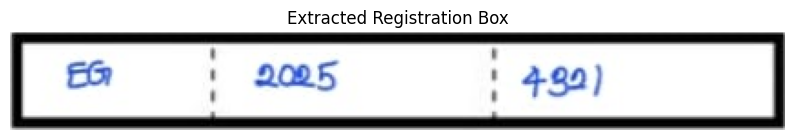

File: EG_2025_4321.jpeg
Ground Truth: EG 2025 4321
Predicted: [INVALID FORMAT]66 9025 490)
----------------------------------------


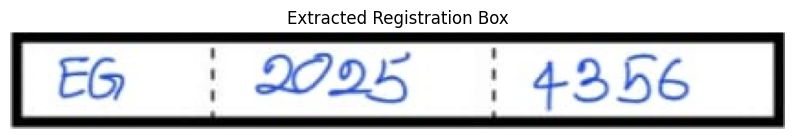

File: EG_2025_4356.jpeg
Ground Truth: EG 2025 4356
Predicted: [INVALID FORMAT]E6 9025 4356
----------------------------------------


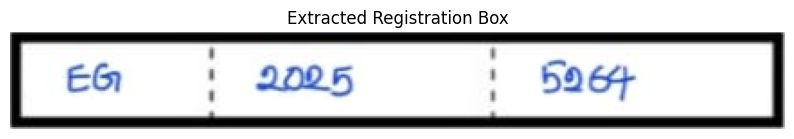

File: EG_2025_5264.jpeg
Ground Truth: EG 2025 5264
Predicted: [INVALID FORMAT]E6 9025 598T
----------------------------------------


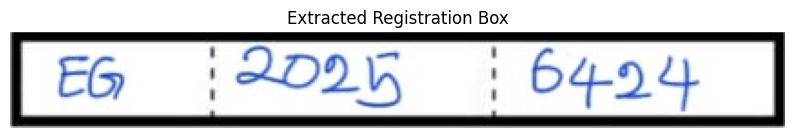

File: EG_2025_6424.jpeg
Ground Truth: EG 2025 6424
Predicted: [INVALID FORMAT]E6 2025 6424
----------------------------------------


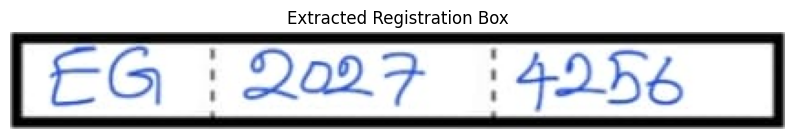

File: EG_2027_4256.jpeg
Ground Truth: EG 2027 4256
Predicted: EG 2027 4256
----------------------------------------


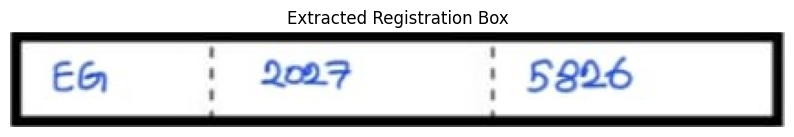

File: EG_2027_5826.jpeg
Ground Truth: EG 2027 5826
Predicted: [INVALID FORMAT]E6 907 5826
----------------------------------------


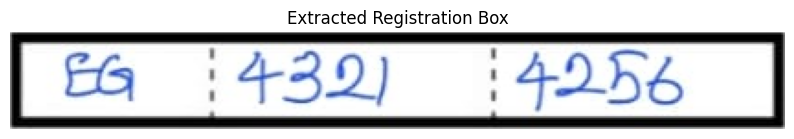

File: EG_4321_4256.jpeg
Ground Truth: EG 4321 4256
Predicted: [INVALID FORMAT]BQ 4321 4256
----------------------------------------


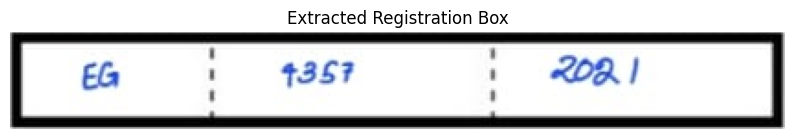

File: EG_4357_2021.jpeg
Ground Truth: EG 4357 2021
Predicted: [INVALID FORMAT]EG 1357 208 |
----------------------------------------


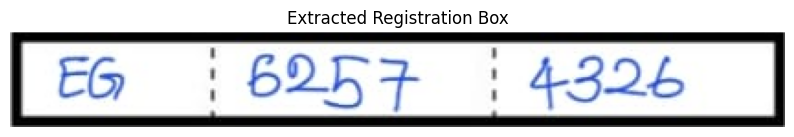

File: EG_6257_4326.jpeg
Ground Truth: EG 6257 4326
Predicted: [INVALID FORMAT]E6 8257 4326
----------------------------------------


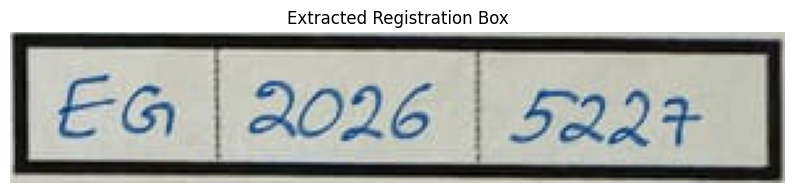

File: EG_2026_5227.jpg
Ground Truth: EG 2026 5227
Predicted: [INVALID FORMAT]EG 3026 5221
----------------------------------------


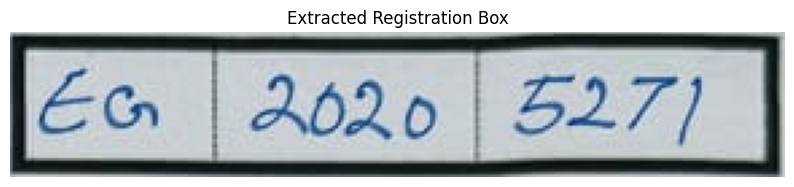

File: EG_2020_5271.jpg
Ground Truth: EG 2020 5271
Predicted: [INVALID FORMAT]66 2020 5271
----------------------------------------


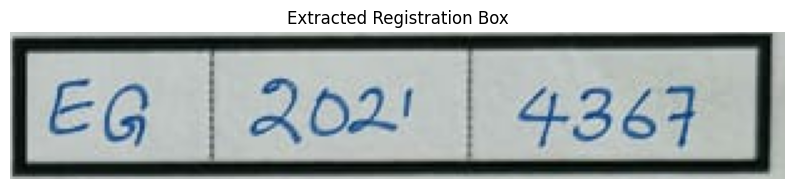

File: EG_2021_4367.jpg
Ground Truth: EG 2021 4367
Predicted: EG 2021 4363
----------------------------------------


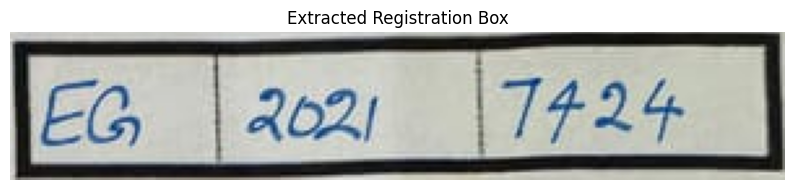

File: EG_2021_7424.jpg
Ground Truth: EG 2021 7424
Predicted: [INVALID FORMAT]EG 2621 7424
----------------------------------------


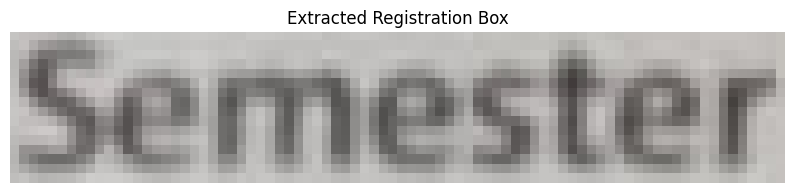

File: EG_2028_4927.jpg
Ground Truth: EG 2028 4927
Predicted: [INVALID FORMAT]SEMESTER
----------------------------------------


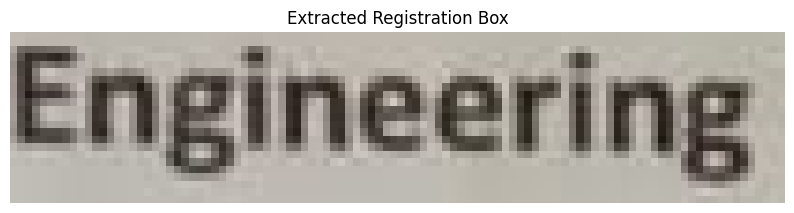

File: EG_2025_4678.jpg
Ground Truth: EG 2025 4678
Predicted: [INVALID FORMAT]ENGINEERING
----------------------------------------


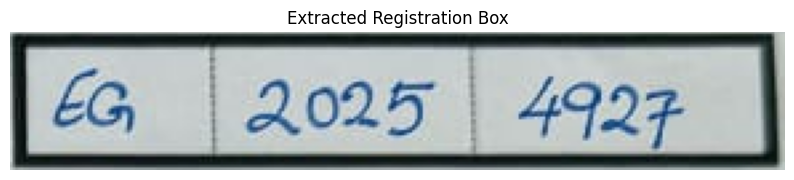

File: EG_2025_4927.jpg
Ground Truth: EG 2025 4927
Predicted: [INVALID FORMAT]EG; 2025 4923
----------------------------------------


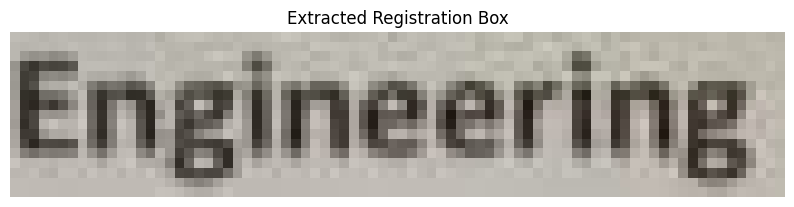

File: EG_2027_4159.jpg
Ground Truth: EG 2027 4159
Predicted: [INVALID FORMAT]ENGINEERING
----------------------------------------


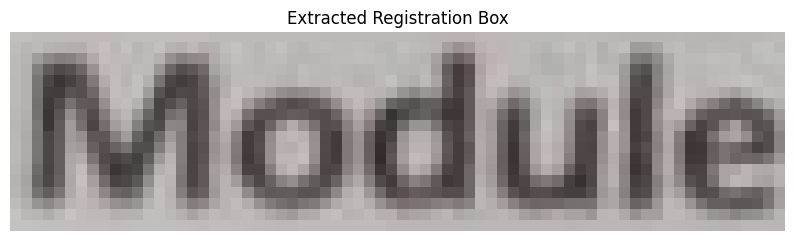

File: EG_2025_4627.jpg
Ground Truth: EG 2025 4627
Predicted: [INVALID FORMAT]MODULE
----------------------------------------


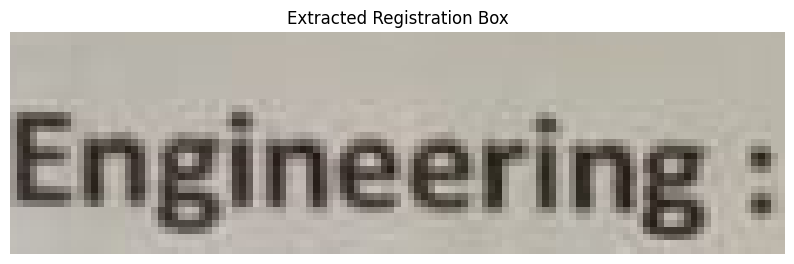

File: EG_2021_8432.jpg
Ground Truth: EG 2021 8432
Predicted: [INVALID FORMAT]ENGINEERING
----------------------------------------
Accuracy: 3/35 = 8.57%


In [7]:
# Process all images and get results
results = process_all_images(dataset_path)

# Calculate accuracy
correct = 0
for r in results:
    # Compare extracted reg number with filename
    if r['ground_truth'] == r['predicted']:
        correct += 1

print(f"Accuracy: {correct}/{len(results)} = {correct/len(results)*100:.2f}%")


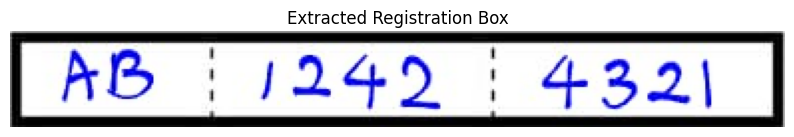

File: AB_1242_4321.jpg
Ground Truth Last 4: 4321
Predicted Last 4: 4321
----------------------------------------


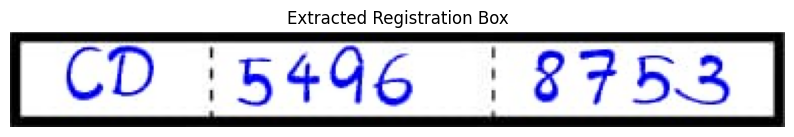

File: CD_5496_8753.jpg
Ground Truth Last 4: 8753
Predicted Last 4: 8753
----------------------------------------


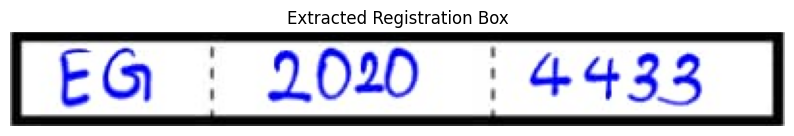

File: EG_2020_4433.jpg
Ground Truth Last 4: 4433
Predicted Last 4: 4433
----------------------------------------


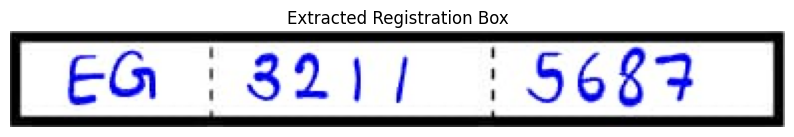

File: EG_3211_5687.jpg
Ground Truth Last 4: 5687
Predicted Last 4: 5687
----------------------------------------


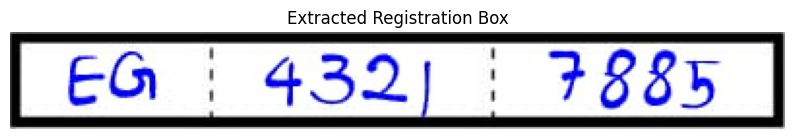

File: EG_4321_7885.jpg
Ground Truth Last 4: 7885
Predicted Last 4: 7885
----------------------------------------


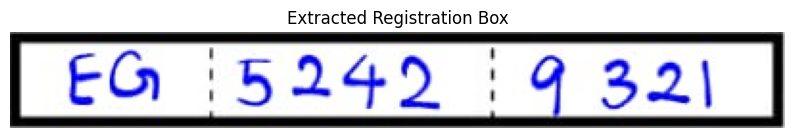

File: EG_5242_9321.jpg
Ground Truth Last 4: 9321
Predicted Last 4: 5242
----------------------------------------


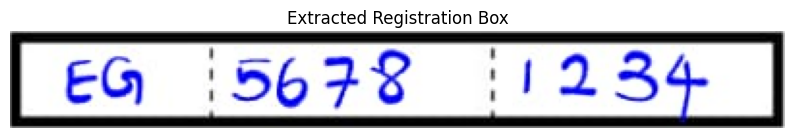

File: EG_5678_1234.jpg
Ground Truth Last 4: 1234
Predicted Last 4: 7234
----------------------------------------


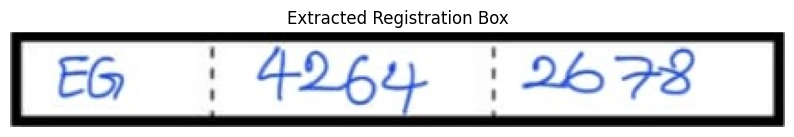

File: EG_2020_2678.jpeg
Ground Truth Last 4: 2678
Predicted Last 4: 2678
----------------------------------------


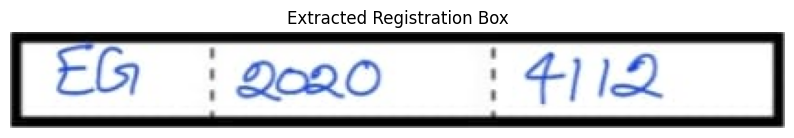

File: EG_2020_4112.jpeg
Ground Truth Last 4: 4112
Predicted Last 4: 4112
----------------------------------------


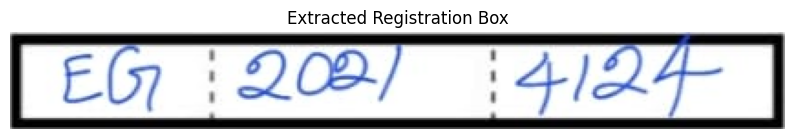

File: EG_2021_4124.jpeg
Ground Truth Last 4: 4124
Predicted Last 4: 1412
----------------------------------------


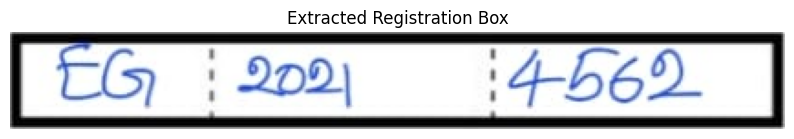

File: EG_2021_4562.jpeg
Ground Truth Last 4: 4562
Predicted Last 4: 4662
----------------------------------------


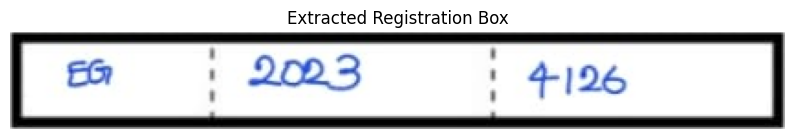

File: EG_2023_4126.jpeg
Ground Truth Last 4: 4126
Predicted Last 4: 4126
----------------------------------------


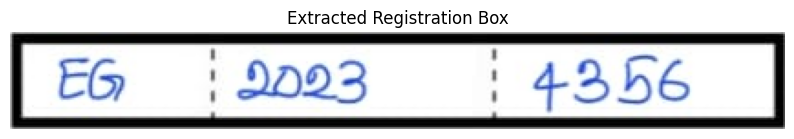

File: EG_2023_4356.jpeg
Ground Truth Last 4: 4356
Predicted Last 4: 4356
----------------------------------------


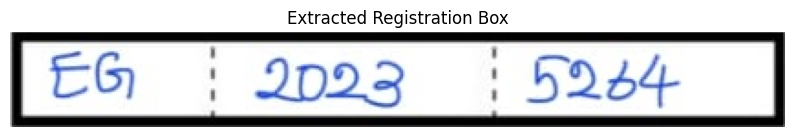

File: EG_2023_5264.jpeg
Ground Truth Last 4: 5264
Predicted Last 4: 5284
----------------------------------------


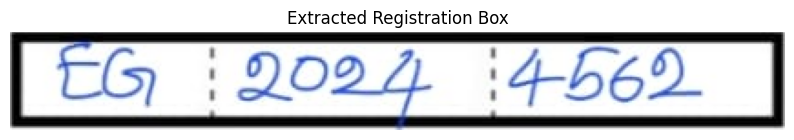

File: EG_2024_4562.jpeg
Ground Truth Last 4: 4562
Predicted Last 4: 2024
----------------------------------------


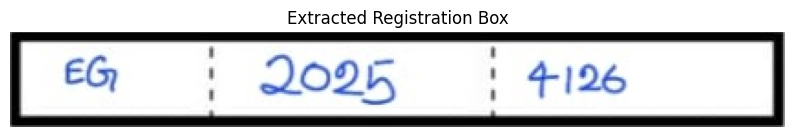

File: EG_2025_4126.jpeg
Ground Truth Last 4: 4126
Predicted Last 4: 4126
----------------------------------------


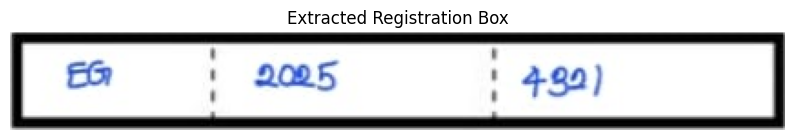

File: EG_2025_4321.jpeg
Ground Truth Last 4: 4321
Predicted Last 4: 9025
----------------------------------------


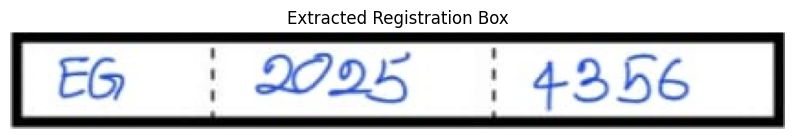

File: EG_2025_4356.jpeg
Ground Truth Last 4: 4356
Predicted Last 4: 4356
----------------------------------------


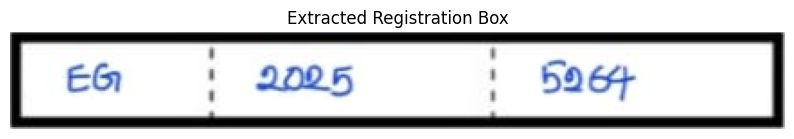

File: EG_2025_5264.jpeg
Ground Truth Last 4: 5264
Predicted Last 4: 9025
----------------------------------------


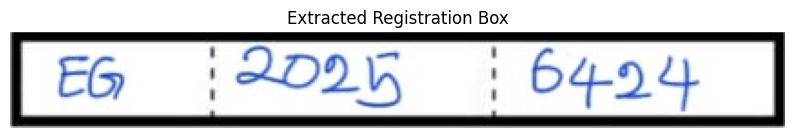

File: EG_2025_6424.jpeg
Ground Truth Last 4: 6424
Predicted Last 4: 6424
----------------------------------------


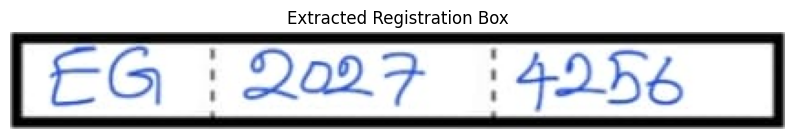

File: EG_2027_4256.jpeg
Ground Truth Last 4: 4256
Predicted Last 4: 4256
----------------------------------------


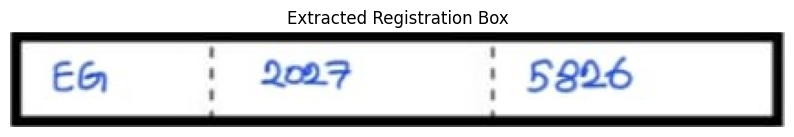

File: EG_2027_5826.jpeg
Ground Truth Last 4: 5826
Predicted Last 4: 5826
----------------------------------------


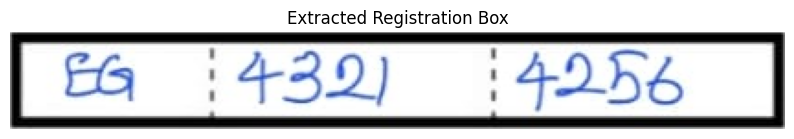

File: EG_4321_4256.jpeg
Ground Truth Last 4: 4256
Predicted Last 4: 4256
----------------------------------------


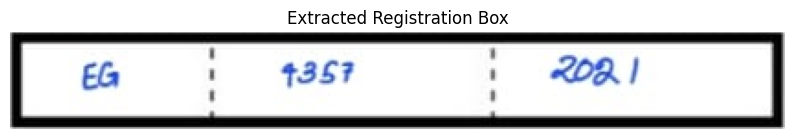

File: EG_4357_2021.jpeg
Ground Truth Last 4: 2021
Predicted Last 4: 1357
----------------------------------------


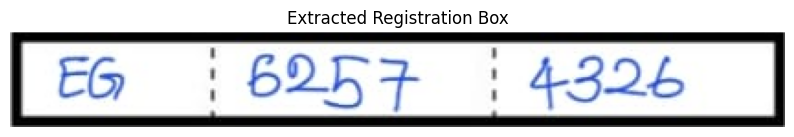

File: EG_6257_4326.jpeg
Ground Truth Last 4: 4326
Predicted Last 4: 4326
----------------------------------------


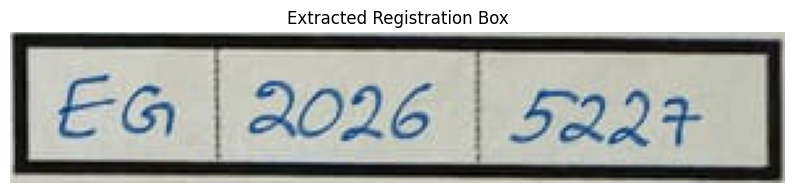

File: EG_2026_5227.jpg
Ground Truth Last 4: 5227
Predicted Last 4: 5221
----------------------------------------


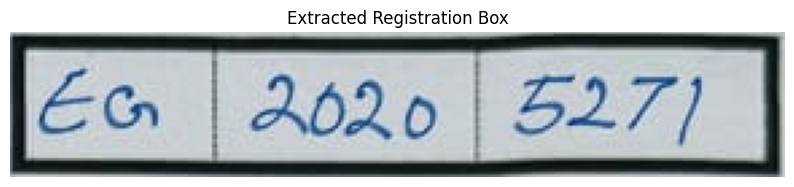

File: EG_2020_5271.jpg
Ground Truth Last 4: 5271
Predicted Last 4: 5271
----------------------------------------


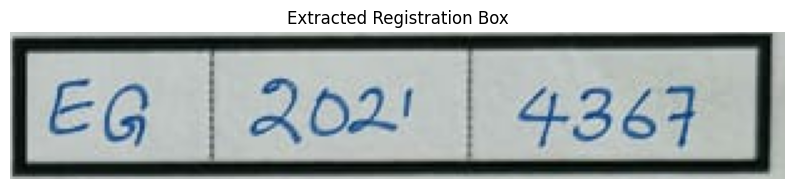

File: EG_2021_4367.jpg
Ground Truth Last 4: 4367
Predicted Last 4: 4363
----------------------------------------


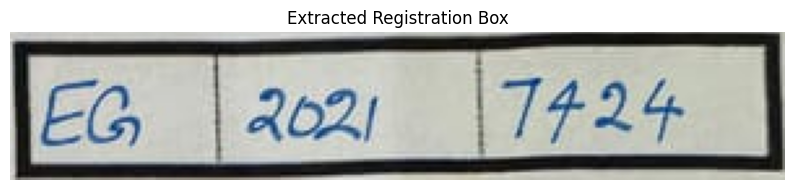

File: EG_2021_7424.jpg
Ground Truth Last 4: 7424
Predicted Last 4: 7424
----------------------------------------


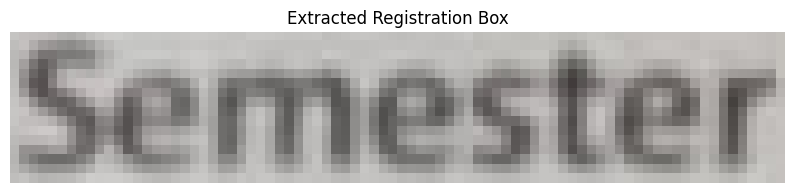

File: EG_2028_4927.jpg
Ground Truth Last 4: 4927
Predicted Last 4: [NO 4 DIGITS]
----------------------------------------


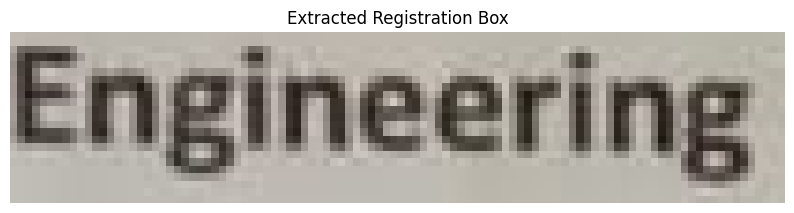

File: EG_2025_4678.jpg
Ground Truth Last 4: 4678
Predicted Last 4: [NO 4 DIGITS]
----------------------------------------


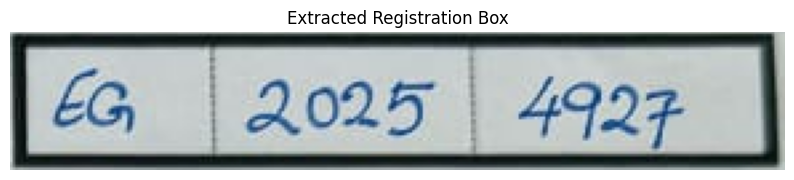

File: EG_2025_4927.jpg
Ground Truth Last 4: 4927
Predicted Last 4: 4923
----------------------------------------


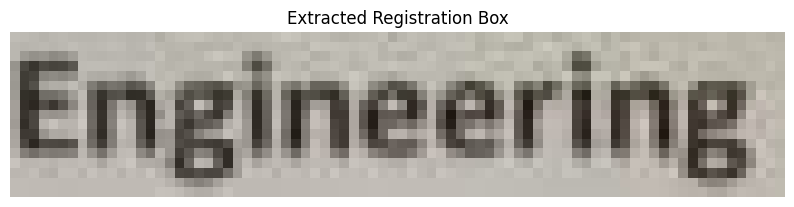

File: EG_2027_4159.jpg
Ground Truth Last 4: 4159
Predicted Last 4: [NO 4 DIGITS]
----------------------------------------


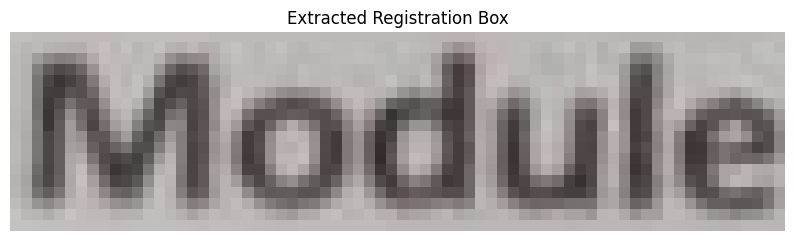

File: EG_2025_4627.jpg
Ground Truth Last 4: 4627
Predicted Last 4: [NO 4 DIGITS]
----------------------------------------


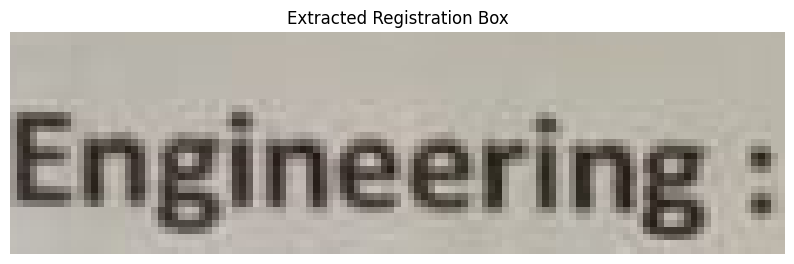

File: EG_2021_8432.jpg
Ground Truth Last 4: 8432
Predicted Last 4: [NO 4 DIGITS]
----------------------------------------
Accuracy: 18/35 = 51.43%


In [11]:
import re

def extract_last4(text):
    """Extracts the last 4-digit sequence from a string."""
    # Find all 4-digit sequences in the text
    matches = re.findall(r'\d{4}', text)
    if matches:
        return matches[-1]  # Return the last 4-digit sequence found
    else:
        # Fallback: get last 4 digits from all digits in string
        digits_only = re.sub(r'\D', '', text)
        return digits_only[-4:] if len(digits_only) >= 4 else "[NO 4 DIGITS]"

def process_all_images(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            ground_truth = os.path.splitext(filename)[0].replace("_", " ")
            roi, predicted_reg = process_registration_number(image_path)
            gt_last4 = extract_last4(ground_truth)
            pred_last4 = extract_last4(predicted_reg)
            results.append({
                'filename': filename,
                'ground_truth_last4': gt_last4,
                'predicted_last4': pred_last4
            })
            print(f"File: {filename}")
            print(f"Ground Truth Last 4: {gt_last4}")
            print(f"Predicted Last 4: {pred_last4}")
            print('-' * 40)
    return results

# Main execution code
dataset_path = '/content/gdrive/MyDrive/OCR_dataset'
results = process_all_images(dataset_path)

# Calculate accuracy based on last 4 digits
correct = 0
for r in results:
    if r['ground_truth_last4'] == r['predicted_last4']:
        correct += 1

print(f"Accuracy: {correct}/{len(results)} = {correct/len(results)*100:.2f}%")